# Predictions statistics

Analysis of the predictions made for a certain datasplit (usually test).

**Note:** To run this notebook you previously have to run and save the predictions on a test dataset **with ground-truth values**. See the Datasplit section in [3.0 notebook](./3.0-Computing_predictions.ipynb#Predicting-a-datasplit-txt-file) for reference.


In [1]:
import os
import json
import numpy as np

from imgclas.data_utils import load_image
from imgclas import paths, plot_utils
from imgclas import test_utils
import sklearn.metrics as metrics
import math
import statistics
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_bin(true_values):
    
    grams = [100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375]
    bins = [87.5, 112.5, 137.5, 162.5, 187.5, 212.5, 237.5, 262.5, 287.5, 312.5, 337.5, 362.5, 387.5]
    
    
    if type(true_values) == list:
        result = list()
        for e in true_values:
            l = len(bins)
            index = 0
            for i in range(l):
                try:
                    if bins[i] < float(e) and bins[i+1] > float(e):
                        index = i
                        result.append(grams[index])
                        break
                except:
                    print("Error:", e)
    else:
        l = len(bins)
        index = 0
        for i in range(l):
            try:
                if bins[i] < float(true_values) and bins[i+1] > float(true_values):
                    index = i
                    result = grams[index]
                    break
            except:
                print("Error:", true_values)
        
    
    return result

In [3]:
def get_sample_predictions(timestamp=None, bootstrapping_predictions_folder=None, sample_name='bootstrapping_sample-', num_sample=0, bin_size=None):
    
    if timestamp == None or bootstrapping_predictions_folder == None:
        raise Exception("timestamp and bootstrapping_predictions_folder parameters needed") 
    
    # Set the timestamp
    paths.timestamp = timestamp

    # Load back the predictions
    pred_path = os.path.join(paths.get_predictions_dir(), '{}/{}{}.json'.format(bootstrapping_predictions_folder, sample_name, num_sample))
    with open(pred_path) as f:
        pred_dict = json.load(f)

    y, y_pred = np.array(pred_dict['true_value']), np.array(pred_dict['pred_value'])
    
    
    if bin_size != None:
        aux_y=[]
        aux_y_pred=[] 
        for (t,p) in zip(y,y_pred):
            if get_bin(t) == bin_size:
                aux_y.append(t)
                aux_y_pred.append(p)
        y = aux_y
        y_pred = aux_y_pred

    return y, y_pred

In [4]:
def compute_error(y, y_pred):
    mae = metrics.mean_absolute_error(y, y_pred)
    
    # Calcular el error residual para el intervalo de confianza 
    errores_absolutos = np.abs(np.array(y) - np.array(y_pred))
    
    # Calcular errores relativos
    errores_relativos = errores_absolutos / y

    
    '''
    #Calculo el error maximo por encima y por debajo
    max_positive_error = -math.inf
    max_negative_error = math.inf
    for (t,p) in zip(y,y_pred):
        error = p-t
        if error > max_positive_error:
            max_positive_error = error
        if error < max_negative_error:
            max_negative_error = error
    '''
        
    return mae, list(errores_absolutos), errores_relativos
    

In [5]:
def bootstrapping_statistics(timestamp=None, bootstrapping_predictions_folder=None, sample_name='bootstrapping-epoch-20', num_samples=1, bin_size=None, conf=0.95):
    
    samples_mae = []
    samples_errores_absolutos = []
    samples_errores_relativos = []
    for i in range(0,num_samples):
        y, y_pred = get_sample_predictions(timestamp, bootstrapping_predictions_folder, sample_name, num_sample=i, bin_size=bin_size)
        mae, error_absoluto, error_relativo = compute_error(y, y_pred)
        
        samples_mae.append(mae)
        samples_errores_absolutos.extend(error_absoluto)
        samples_errores_relativos.extend(error_relativo)
    
    mae = statistics.mean(samples_mae)
    confidence_interval = stats.t.interval(conf, len(samples_errores_absolutos)-1, loc=np.mean(samples_errores_absolutos), scale=stats.sem(samples_errores_absolutos))
    error_relativo_promedio = np.mean(samples_errores_relativos)
    
    return mae, confidence_interval, error_relativo_promedio

# General bootstrapping statistics

In [6]:
mae, confidence_interval, error_relativo_promedio = bootstrapping_statistics(timestamp='2024-02-01_115602', 
                                                   bootstrapping_predictions_folder='bootstrapping-epoch-20',
                                                   sample_name='bootstrapping_sample-', num_samples=100, conf=0.95)
print("MAE: ",mae, "±", error_relativo_promedio)
print("95% Intervalo de confianza: ", confidence_interval)

MAE:  27.379299965667723 ± 0.11723253231577248
95% Intervalo de confianza:  (27.239995776957734, 27.518604154377712)


# Bootstrapping statistics by size


In [7]:
#Example 200 grams
mae, confidence_interval, error_relativo_promedio = bootstrapping_statistics(timestamp='2024-02-01_115602', 
                                                                       bootstrapping_predictions_folder='bootstrapping-epoch-20', 
                                                                       sample_name='bootstrapping_sample-', num_samples=100, bin_size=200)
print("MAE: ",mae, "±", error_relativo_promedio)
print("95% Intervalo de confianza: ", confidence_interval)

MAE:  17.19340077006645 ± 0.08574024726087597
95% Intervalo de confianza:  (16.966640984625823, 17.420681177945543)


# Real Test statistics

In [8]:
# User parameters to set
TIMESTAMP = '2024-02-01_115602'       # timestamp of the model              
SPLIT_NAME = 'test'                   # dataset split to predict
MODEL_NAME = 'epoch-20.hdf5'         # model to use to make the mediction

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load back the predictions
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}.json'.format(MODEL_NAME, SPLIT_NAME))
with open(pred_path) as f:
    pred_dict = json.load(f)
    
y, y_pred = np.array(pred_dict['true_value']), np.array(pred_dict['pred_value'])
    
mae, errores_absolutos, errores_relativos = compute_error(y, y_pred)

confidence_interval = stats.t.interval(0.95, len(errores_absolutos)-1, loc=np.mean(errores_absolutos), scale=stats.sem(errores_absolutos))
error_relativo_promedio = np.mean(errores_relativos)
    
print("MAE: ",mae, "±", error_relativo_promedio)
print("95% Intervalo de confianza: ", confidence_interval)

MAE:  21.837328576329927 ± 0.1048374968606077
95% Intervalo de confianza:  (21.054642617853897, 22.620014534805957)


# PLOT CREATION


## Violin plots


In [9]:
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import os
import json
import numpy as np
from imgclas.data_utils import load_image
from imgclas import paths, plot_utils
import warnings
warnings.filterwarnings("ignore")


In [10]:
# User parameters to set
TIMESTAMP = '2024-02-01_115602'       # timestamp of the model              
SPLIT_NAME = 'test'                   # dataset split to predict
MODEL_NAME = 'epoch-20.hdf5'         # model to use to make the mediction

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load back the predictions
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}.json'.format(MODEL_NAME, SPLIT_NAME))
with open(pred_path) as f:
    pred_dict = json.load(f)

# plotly figure
df = pd.DataFrame(data={'true_volume': pred_dict['true_value'], 'pred_volume': pred_dict['pred_value'], 'bin': get_bin(pred_dict['true_value'])})

#fig = go.Figure()
volumes = [100, 125, 150, 175, 200, 225, 250, 275, 300, 325]


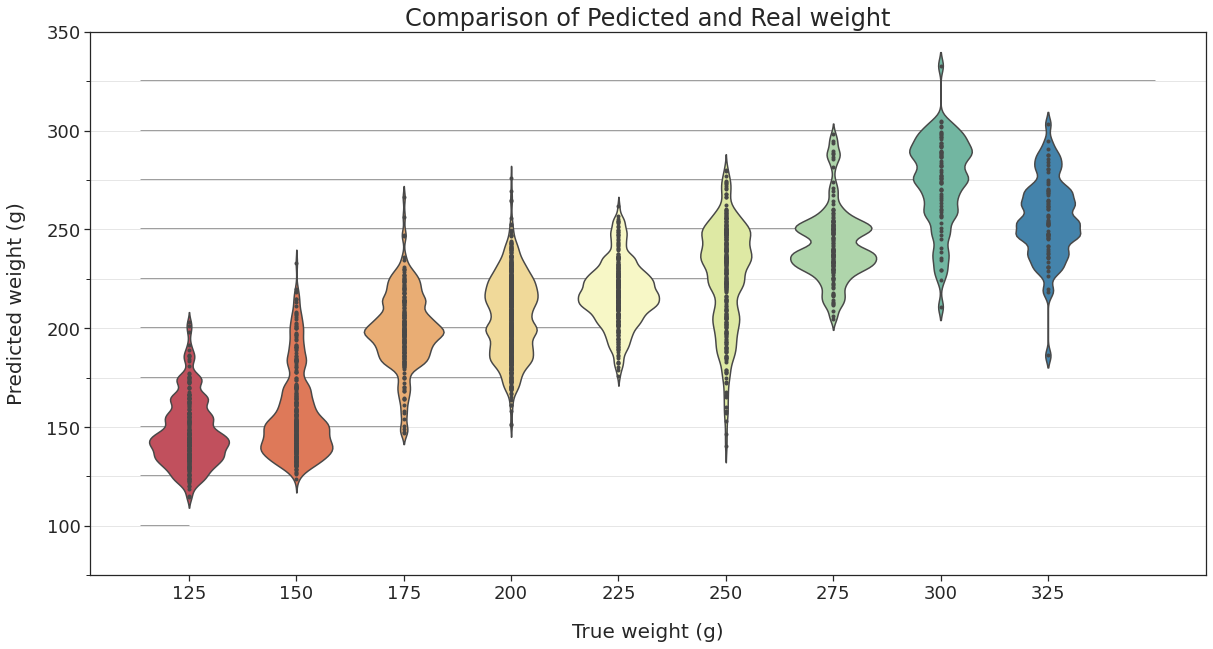

In [21]:
# seaborn figure


sns.set_theme()
sns.set_style(style='white') 

fig, ax = plt.subplots(1,1)
    
sns.violinplot(x='bin',
                    y='pred_volume',
                    data=df, inner="points",
                    palette="Spectral",
               scatter_kws={"zorder":10},
               ax=ax,
               bw=.15, #not smooth
              )

for i, v in enumerate(volumes):
    xrange = np.linspace(-0.45, i, 100)
    ax.plot(xrange, [v]*len(xrange), zorder=-1, color='0.5')
#     sns.lineplot(xrange, [v]*len(xrange), color='0.5', ax=ax)
    
# ax.set(xlabel='True volume (mL)', ylabel='Predicted volume (mL)')
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
ax.set_xlabel(xlabel='True weight (g)', labelpad=20, fontsize=20)
ax.set_ylabel(ylabel='Predicted weight (g)', labelpad=20, fontsize=20)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
# sns.boxplot(x='true_volume', y='pred_volume', data=df, palette='rainbow', width=0.3,
#             boxprops={'zorder': 2}, ax=ax)
# plt.title("Predicted volumes distribution", fontsize=22)
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(25))
plt.grid(axis='y', which='both', color='0.9')
plt.rcParams["figure.figsize"] = (20,10)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
    
plt.ylim([75, 350])
plt.setp(ax.collections, alpha=1)
plt.title('Comparison of Pedicted and Real weight', fontsize=24)
# plt.scatter(x=range(len(volumes)),y=volumes, c="powderblue",              marker='X', s=100, edgecolor='navy')
plt.savefig('/srv/image-results/violin_plot_general.png',bbox_inches='tight')
plt.show()

## Plot MAE, Intervalo de Confianza y Error Relativo

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

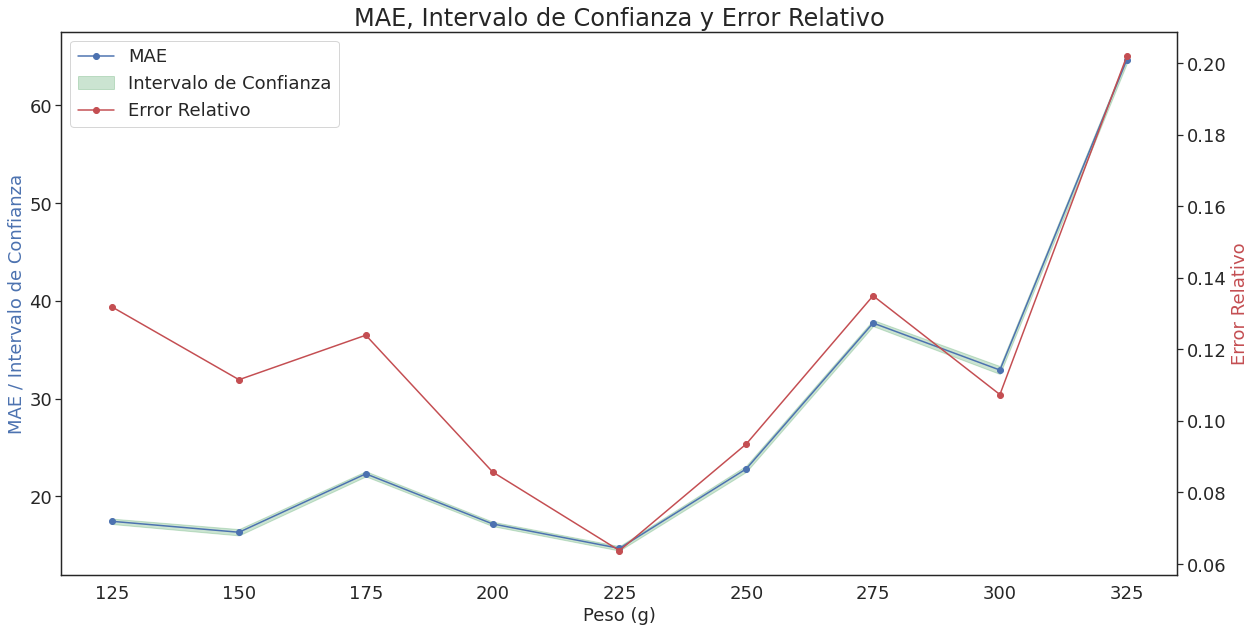

In [19]:
sizes = [125, 150, 175, 200, 225, 250 ,275, 300, 325]


mae_by_size=[]
errorRelativo_by_size=[]
ic_by_size=[]
for s in sizes:
    mean_absolute_error, confidence_interval, error_relativo_promedio = bootstrapping_statistics(timestamp='2024-02-01_115602', 
                                                                           bootstrapping_predictions_folder='bootstrapping-epoch-20', 
                                                                           sample_name='bootstrapping_sample-', num_samples=100, bin_size=s)
    mae_by_size.append(mean_absolute_error)
    errorRelativo_by_size.append(error_relativo_promedio)
    ic_by_size.append(confidence_interval)
    
intervalo_confianza_min = [ic[0] for ic in ic_by_size]
intervalo_confianza_max = [ic[1] for ic in ic_by_size]
    
# Crear subgráficos
fig, ax1 = plt.subplots(figsize=(20, 10))

# Graficar MAE y intervalo de confianza
ax1.plot(sizes, mae_by_size, marker='o', color='b', label='MAE')
ax1.fill_between(sizes, intervalo_confianza_min, intervalo_confianza_max, color='g', alpha=0.3, label='Intervalo de Confianza')
ax1.set_xlabel('Peso (g)', fontsize=18)
ax1.set_ylabel('MAE / Intervalo de Confianza', color='b', fontsize=18)

# Crear segundo eje y graficar el error relativo
ax2 = ax1.twinx()
ax2.plot(sizes, errorRelativo_by_size, marker='o', color='r', label='Error Relativo')
ax2.set_ylabel('Error Relativo', color='r', fontsize=18)

# Añadir leyendas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=18)

ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)


# Mostrar gráfico
plt.title('MAE, Intervalo de Confianza y Error Relativo', fontsize=24)
plt.savefig('/srv/image-results/MAE_IC_plot.png',bbox_inches='tight')
plt.show()

# Plot MAE


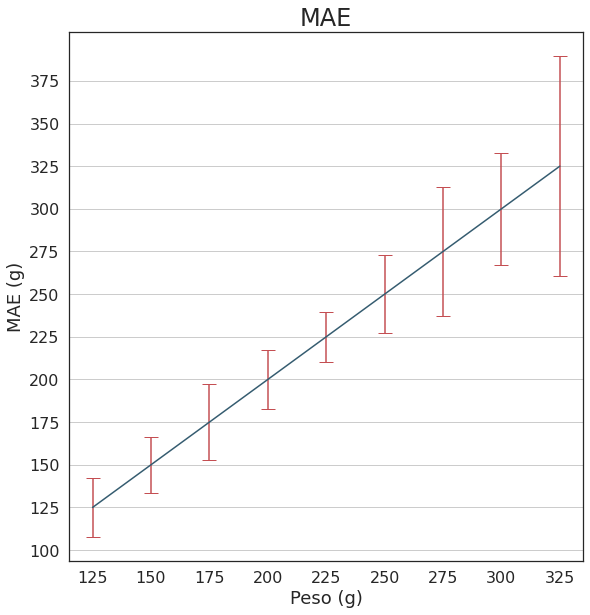

In [49]:
sizes = [125, 150, 175, 200, 225, 250 ,275, 300, 325]
mae_by_size=[]
for s in sizes:
    mean_absolute_error, confidence_interval, error_relativo_promedio = bootstrapping_statistics(timestamp='2024-02-01_115602', 
                                                                           bootstrapping_predictions_folder='bootstrapping-epoch-20', 
                                                                           sample_name='bootstrapping_sample-', num_samples=100, bin_size=s)
    mae_by_size.append(mean_absolute_error)

df = pd.DataFrame({'Size': sizes, 'MAE': mae_by_size})

#Create plot
figsize = 3
fig, axs = plt.subplots(figsize=(figsize*3, figsize*3))


df.plot(y='Size', yerr='MAE', ax=axs, color=['#355c70'], ecolor='r', capsize=7, legend=None)
axs.set_xlabel('Peso (g)', fontsize=18)
axs.set_ylabel('MAE (g)', fontsize=18)
axs.tick_params(axis='x', rotation=0)
axs.tick_params(axis='both', which='major', labelsize=16)
axs.yaxis.grid(True)

axs.set_xticks(range(len(sizes)))
axs.set_xticklabels(sizes)

axs.set_yticks(range(100, 400, 25))

fig.tight_layout(pad=3.0)
plt.title('MAE', fontsize=24)
plt.savefig('/srv/image-results/MAE.png',bbox_inches='tight')
plt.show()